# <center>Audio Emotion classifier</center>
## <center>Part 1 - Data Exploration</center>
#### <center> 19th August 2019 </center> 
#####  <center> Eu Jin Lok </center> 



# Introduction 
We are going to build an audio emotion classifier. But why you ask, are we doing this? Well, for a few reasons: 

- **Its becoming fairly important**<br/>
At least, here in Australia, due to the recent fallout of the Royal Commision, there's more scrutiny than ever into the financial sector. One of the areas that traditionaly have been ingored by the government is contact centres, many of these generate contracts through telephone conversations. So compliance is a hot topic right now 

- **Because we can**<br/>
With recent advancements of Deep Learning, better hardware and more open sourcing of data, this enables us to build the capability that we couldn't before. So, why not.  

- **Accessibility**<br/>
I've specifically chosen emotion as our target because its one of the more accesible **labeled** dataset. Don't misunderstand, there are many good quality audio datasets out there, but many are either not relevant (eg. background noises), or locked behind paid wall. Emotions are probably relevant enough since we are dealing with conversations between agent and customer, and there's variety of sources. Also, emotions are general enough (not context dependent), so we can apply to a vast number of different projects

This is going to be a 6 to 7 part series at least. Could be more, but not less. Part 2 covers feature extraction whilst Part 3 and 4 we will dive into the modelling. But to train a model, we need data. So Part 1 here, we are going to check out a few data sources which are all open sourced:

- Surrey Audio-Visual Expressed Emotion [(SAVEE)](https://www.kaggle.com/ejlok1/surrey-audiovisual-expressed-emotion-savee)
- Ryerson Audio-Visual Database of Emotional Speech and Song [(RAVDESS)](https://www.kaggle.com/uwrfkaggler/ravdess-emotional-speech-audio)
- Toronto emotional speech set [(TESS)](https://www.kaggle.com/ejlok1/toronto-emotional-speech-set-tess)
- Crowd-sourced Emotional Mutimodal Actors Dataset [(CREMA-D)](https://www.kaggle.com/ejlok1/cremad)

The ultimate end game is to get the best accuracy that will generalise across unseen data. Right now its unclear how we mix and match (or excluded) our datasets so that's why we need to explore it first. So lets begin

### Contents
1. [SAVEE dataset](#savee)
    * [Load the dataset](#savee_load)
    * [Explore the data](#savee_explore)
    * [Conclusion](#savee_con)
2. [RAVDESS dataset](#ravdess)
    * [Load the dataset](#ravdess_load)
    * [Explore the data](#ravdess_explore)
    * [Conclusion](#ravdess_con)
3. [TESS dataset](#tess)
    * [Load the dataset](#tess_load)
    * [Explore the data](#tess_explore)
    * [Conclusion](#tess_con)
4. [CREMA-D dataset](#crema)
    * [Load the dataset](#crema_load)
    * [Explore the data](#crema_explore)
    * [Conclusion](#crema_con)
5. [Final thoughts](#final)

Note that the other parts are now available:
* [Part 2 | Feature Extract](https://www.kaggle.com/ejlok1/audio-emotion-part-2-feature-extract)
* [Part 3 | Baseline model](https://www.kaggle.com/ejlok1/audio-emotion-part-3-baseline-model)
* [Part 4 | Apply to new audio data](https://www.kaggle.com/ejlok1/audio-emotion-part-4-apply-to-new-audio-data)
* [Part 5 | Data augmentation](https://www.kaggle.com/ejlok1/audio-emotion-part-5-data-augmentation)

In [2]:
# Import libraries 
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from matplotlib.pyplot import specgram
import pandas as pd
import glob 
from sklearn.metrics import confusion_matrix
import IPython.display as ipd  # To play sound in the notebook
import os
import sys
import warnings
# ignore warnings 
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning) 

The 4 sources of the datasets are all on Kaggle so I've just imported them into the workspace. The directory path to the 4 sources in this environment are below:

In [3]:
#for dirname, _, filenames in os.walk('/kaggle/input'):
#    for filename in filenames:
#        print(os.path.join(dirname, filename))

TESS = "E:/Dataset/TESS/TESS Toronto emotional speech set data/TESS Toronto emotional speech set data/"
RAV = "E:/Dataset/RAVDESS/audio/"
SAVEE = "E:/Dataset/SAVEE/ALL/"
CREMA = "E:/Dataset/CREMA/AudioWAV/"
# Run one example 
dir_list = os.listdir(SAVEE)
dir_list[0:5]

['DC_a01.wav', 'DC_a02.wav', 'DC_a03.wav', 'DC_a04.wav', 'DC_a05.wav']

<a id="savee"></a>
##  <center> 1. SAVEE dataset <center>
The audio files are named in such a way that the prefix letters describes the emotion classes as follows:
- 'a' = 'anger'
- 'd' = 'disgust'
- 'f' = 'fear'
- 'h' = 'happiness'
- 'n' = 'neutral'
- 'sa' = 'sadness'
- 'su' = 'surprise' 

The original source has 4 folders each representing a speaker, but i've bundled all of them into one single folder and thus the first 2 letter prefix of the filename represents the speaker initials. Eg. 'DC_d03.wav' is the 3rd disgust sentence uttered by the speaker DC. It's  worth nothing that they are all male speakers only. This isn't an issue as we'll balance it out with the TESS dataset which is just female only. So lets check out the distribution of the emotions...

<a id="savee_load"></a>
###  Load the dataset 
I'm not going to be reading the entire audio to memory. Rather I'm just going to read the meta-data associated with it. Cause at this point I just want a high level snapshot of some statistics. And then I might just load 1 or 2 audio files and expand on it. 

So lets take 2 different emotions and play it just to get a feel for what we are dealing with. Ie. whether the data (audio) quality is good. It gives us an early insight as to how likely our classifier is going to be successful.  

In [4]:
# Get the data location for SAVEE
dir_list = os.listdir(SAVEE)

# parse the filename to get the emotions
emotion=[]
path = []
for i in dir_list:
    if i[-8:-6]=='_a':
        emotion.append('male_angry')
    elif i[-8:-6]=='_d':
        emotion.append('male_disgust')
    elif i[-8:-6]=='_f':
        emotion.append('male_fear')
    elif i[-8:-6]=='_h':
        emotion.append('male_happy')
    elif i[-8:-6]=='_n':
        emotion.append('male_neutral')
    elif i[-8:-6]=='sa':
        emotion.append('male_sad')
    elif i[-8:-6]=='su':
        emotion.append('male_surprise')
    else:
        emotion.append('male_error') 
    path.append(SAVEE + i)
    
# Now check out the label count distribution 
SAVEE_df = pd.DataFrame(emotion, columns = ['labels'])
SAVEE_df['source'] = 'SAVEE'
SAVEE_df = pd.concat([SAVEE_df, pd.DataFrame(path, columns = ['path'])], axis = 1)
SAVEE_df.labels.value_counts()

male_neutral     120
male_sad          60
male_disgust      60
male_surprise     60
male_happy        60
male_angry        60
male_fear         60
Name: labels, dtype: int64

<a id="savee_explore"></a>
### Explore the data
So a quick introduction about the audio data before we carry on too far. A sound is a vibration of air molecules, and our eardrums interprets it as sound, or music. The below wave plot is a graphical representation of a sound wave vibration overtime. Its in this wave that we need to find the key pattern that will help us distinguish the different emotions. 

There's a nice website that gives a very nice summary of the core audio concepts [here](http://help.nchsoftware.com/help/en/wavepad/win/concepts.html). We're going to plot one or two audio files here selected randomly, just to get a feel for the type of data we're dealing with. Eg. Does it contain lots of background noise? Is the emotions clear? etc. The idea being that, if a human struggles to interpret the data, then its very likely the model isn't going to do a very good job either. 

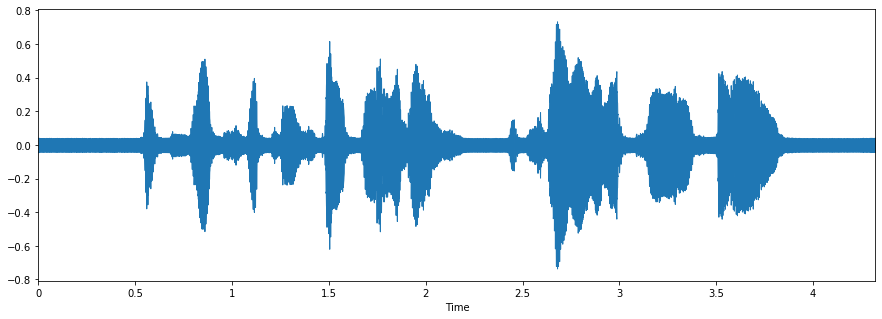

In [5]:
# use the well known Librosa library for this task 
fname = SAVEE + 'DC_f11.wav'  
data, sampling_rate = librosa.load(fname)
plt.figure(figsize=(15, 5))
librosa.display.waveplot(data, sr=sampling_rate)

# Lets play the audio 
ipd.Audio(fname)

So that's a fearful sample. Not alot of background noise and the speech is very clear. So that's good news for us in terms of data quality. The wave plot doesn't really tell much other than there's a variation in the wave, which is good. If it was just a constant oscilating wave form, like those heart-rate-monitors ... then we definitely have a problem. 

But we don't which is great. And we can also tell that the audio file is 3 secs. That's good. Its long enough for someone to express an emotion in a sentence, and not too long such that the emotions changes to neutral. How about we play a happy audio file and see how different they are? 

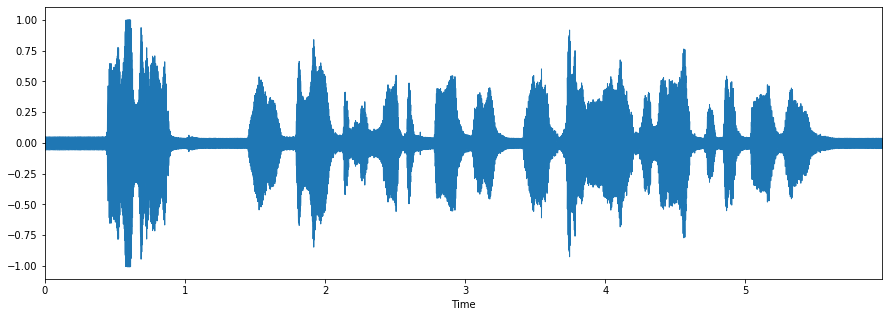

In [6]:
# Lets play a happy track
fname = SAVEE + 'DC_h11.wav'  
data, sampling_rate = librosa.load(fname)
plt.figure(figsize=(15, 5))
librosa.display.waveplot(data, sr=sampling_rate)

# Lets play the audio 
ipd.Audio(fname)

<a id="savee_con"></a>
### Conclusion
So again, good quality audio. And I can see that the wave form is distinctively different from the fear one. So that's good for our model. I did notice that there's a very short silence period between start and end. We could potentially trim it later to enhance the quality. Also, the sentence uttered is different so its not exactly an apple to apple comparison but it still gives us a good early indication of what we're dealing with. 

All in all, I'm happy with this data. We're going to use it for our audio emotion classifier. Now lets look at our next audio dataset...

<a id="ravdess"></a>
## <center>2. RAVDESS dataset</center>

RAVDESS is one of the more common dataset used for this excercise by others. It's well liked because of its quality of speakers, recording and it has 24 actors of different genders. And there's more! You can get it in song format as well. There's something for everyone and their research project. So for convenience, here's the filename identifiers as per the official RAVDESS website:

- Modality (01 = full-AV, 02 = video-only, 03 = audio-only).
- Vocal channel (01 = speech, 02 = song).
- Emotion (01 = neutral, 02 = calm, 03 = happy, 04 = sad, 05 = angry, 06 = fearful, 07 = disgust, 08 = surprised).
- Emotional intensity (01 = normal, 02 = strong). NOTE: There is no strong intensity for the 'neutral' emotion.
- Statement (01 = "Kids are talking by the door", 02 = "Dogs are sitting by the door").
- Repetition (01 = 1st repetition, 02 = 2nd repetition).
- Actor (01 to 24. Odd numbered actors are male, even numbered actors are female).

So, here's an example of an audio filename. 
_02-01-06-01-02-01-12.mp4_

This means the meta data for the audio file is:
- Video-only (02)
- Speech (01)
- Fearful (06)
- Normal intensity (01)
- Statement "dogs" (02)
- 1st Repetition (01)
- 12th Actor (12) - Female (as the actor ID number is even)

At my early beginings embarking on this journey, I learnt through the hard way that male and female speakers have to be trained seperately or the model will struggle to get a good accuracy. From reading a few blogs and articles, it seems female has a higher pitch that male. So if we don't tag the gender label to the audio file, it won't be able to detect anger or fear if it was a male speaker. It will just get bucketed into neutral 

Lets specifically model the 2 speakers seperately. Note that there's a 'calm' emotion and a 'neutral' emotion as seperate. I don't really know the difference but for now, I'll just combined them into the same category.

<a id="ravdess_load"></a>
###  Load the dataset 
Because of the way the entire data was packaged for us, and the format of the audio filename, there's a few more parsing steps required for the RAVDESS dataset compared to SAVEE 

In [7]:
dir_list = os.listdir(RAV)
dir_list.sort()

emotion = []
gender = []
path = []
for i in dir_list:
    fname = os.listdir(RAV + i)
    for f in fname:
        part = f.split('.')[0].split('-')
        emotion.append(int(part[2]))
        temp = int(part[6])
        if temp%2 == 0:
            temp = "female"
        else:
            temp = "male"
        gender.append(temp)
        path.append(RAV + i + '/' + f)

        
RAV_df = pd.DataFrame(emotion)
RAV_df = RAV_df.replace({1:'neutral', 2:'neutral', 3:'happy', 4:'sad', 5:'angry', 6:'fear', 7:'disgust', 8:'surprise'})
RAV_df = pd.concat([pd.DataFrame(gender),RAV_df],axis=1)
RAV_df.columns = ['gender','emotion']
RAV_df['labels'] =RAV_df.gender + '_' + RAV_df.emotion
RAV_df['source'] = 'RAVDESS'  
RAV_df = pd.concat([RAV_df,pd.DataFrame(path, columns = ['path'])],axis=1)
RAV_df = RAV_df.drop(['gender', 'emotion'], axis=1)
RAV_df.labels.value_counts()

male_neutral       144
female_neutral     144
female_happy        96
female_angry        96
female_sad          96
male_angry          96
male_sad            96
male_disgust        96
male_happy          96
female_surprise     96
female_disgust      96
male_fear           96
male_surprise       96
female_fear         96
Name: labels, dtype: int64

<a id="ravdess_explore"></a>
### Explore the data
Lets do the same thing again, take 2 audio files, play it and plot it to see what we're dealing with. And how different they are to SAVEE as we go along. Lets start with a fearful track

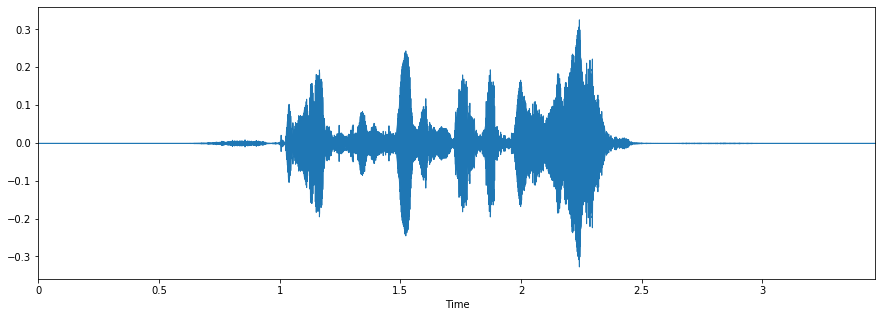

In [8]:
# Pick a fearful track
fname = RAV + 'Actor_14/03-01-06-02-02-02-14.wav'  
data, sampling_rate = librosa.load(fname)
plt.figure(figsize=(15, 5))
librosa.display.waveplot(data, sr=sampling_rate)

# Lets play the audio 
ipd.Audio(fname)

Excellent audio quality. And well acted out. I think you can genuinely feel the fear from the speaker. I do notice that there's a lot of silence between the start and end. We'll address it later in later parts. Lets play another random file, maybe a happy one this time.

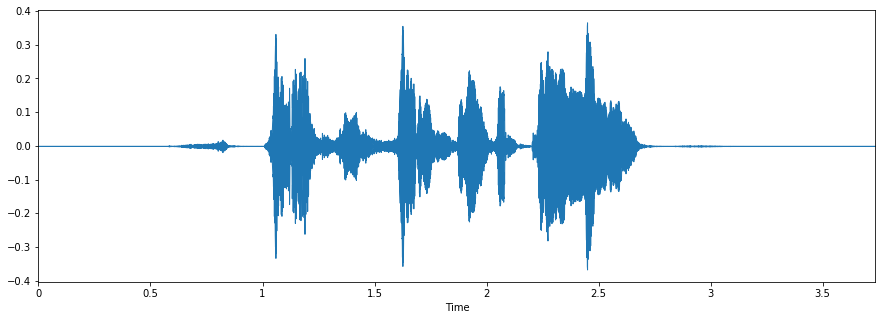

In [9]:
# Pick a happy track
fname = RAV + 'Actor_14/03-01-03-02-02-02-14.wav'  
data, sampling_rate = librosa.load(fname)
plt.figure(figsize=(15, 5))
librosa.display.waveplot(data, sr=sampling_rate)

# Lets play the audio 
ipd.Audio(fname)

<a id="ravdess_con"></a>
### Conclusion
...ok, to be fairly honest, I actual felt like that was a fearful tone at the start, up until the end. I had to play it 3 or 4 times to finally be convienced that it is indeed a happy sound. Looking at the wave plot between the 2 files, I notice the only real difference is the amplitute wherein this happy track has a higher amplituted at various points. But, could be coincidence, who knows at this stage. 

What I do know is that the audio quality is good and we need females in the dataset. If we don't include females, we'll end up with an AI that is bias towards / aagainst one gender, and its unethical. Unless there's a good reason, I'm not taking it out.  

<a id="tess"></a>
##  <center> 3. TESS dataset <center>
Now on to the TESS dataset, its worth nothing that it's only based on 2 speakers, a young female and an older female. This should hopefully balance out the male dominant speakers that we have on SAVEE. 

Its got the same 7 key emotions we're interested in. But what is slightly different about this dataset compared to the previous two above, is that the addition of 'pleasant surprise' emotion. I haven't really checked to see for the RADVESS and SAVEE dataset, if the surpises are unpleasant. But I'm going to work with the assumption for now that its a pleasant surprise. If we find out from post modelling, surpise is highly inaccurate, we can come back and modify our assumption here. 

<a id="tess_load"></a>
###  Load the dataset 
The speakers and the emotions are organised in seperate folders which is very convenient

In [10]:
dir_list = os.listdir(TESS)
dir_list.sort()
dir_list

['OAF_Fear',
 'OAF_Pleasant_surprise',
 'OAF_Sad',
 'OAF_angry',
 'OAF_disgust',
 'OAF_happy',
 'OAF_neutral',
 'YAF_angry',
 'YAF_disgust',
 'YAF_fear',
 'YAF_happy',
 'YAF_neutral',
 'YAF_pleasant_surprised',
 'YAF_sad']

In [11]:
path = []
emotion = []

for i in dir_list:
    fname = os.listdir(TESS + i)
    for f in fname:
        if i == 'OAF_angry' or i == 'YAF_angry':
            emotion.append('female_angry')
        elif i == 'OAF_disgust' or i == 'YAF_disgust':
            emotion.append('female_disgust')
        elif i == 'OAF_Fear' or i == 'YAF_fear':
            emotion.append('female_fear')
        elif i == 'OAF_happy' or i == 'YAF_happy':
            emotion.append('female_happy')
        elif i == 'OAF_neutral' or i == 'YAF_neutral':
            emotion.append('female_neutral')                                
        elif i == 'OAF_Pleasant_surprise' or i == 'YAF_pleasant_surprised':
            emotion.append('female_surprise')               
        elif i == 'OAF_Sad' or i == 'YAF_sad':
            emotion.append('female_sad')
        else:
            emotion.append('Unknown')
        path.append(TESS + i + "/" + f)

TESS_df = pd.DataFrame(emotion, columns = ['labels'])
TESS_df['source'] = 'TESS'
TESS_df = pd.concat([TESS_df,pd.DataFrame(path, columns = ['path'])],axis=1)
TESS_df.labels.value_counts()

female_surprise    400
female_disgust     400
female_fear        400
female_happy       400
female_angry       400
female_sad         400
female_neutral     400
Name: labels, dtype: int64

<a id="tess_explore"></a>
### Explore the data
400 files for each key emotion. Nice. So lets do the same thing again, take 2 audio files, play it and plot it to see what we're dealing with. Lets start with a fearful track

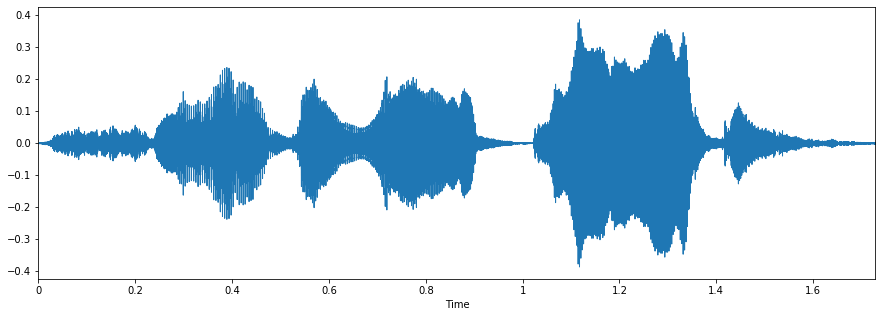

In [12]:
# lets play a fearful track 
fname = TESS + 'YAF_fear/YAF_dog_fear.wav' 

data, sampling_rate = librosa.load(fname)
plt.figure(figsize=(15, 5))
librosa.display.waveplot(data, sr=sampling_rate)

# Lets play the audio 
ipd.Audio(fname)

She sound almost the same as the female speaker from RAVDESS. Maybe when I have time I will go and investigate but for now,  the most important insight for me is that the expression of the emotions are very similar to RAVDESS and thus is a good indication it will serve as a good training dataset

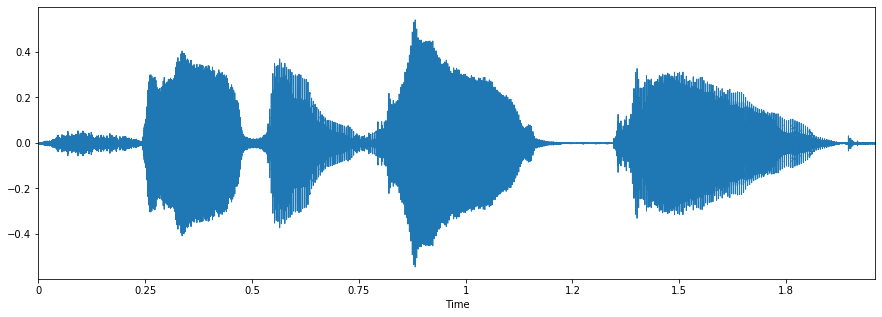

In [13]:
# lets play a happy track 
fname =  TESS + 'YAF_happy/YAF_dog_happy.wav' 

data, sampling_rate = librosa.load(fname)
plt.figure(figsize=(15, 5))
librosa.display.waveplot(data, sr=sampling_rate)

# Lets play the audio 
ipd.Audio(fname)

<a id="tess_con"></a>
### Conclusion
Thats a beautiful happy voice, I played it a few times I must admit. Notice the amplitute is pretty high too on a few data points? We saw that on the RAVDESS dataset too. Perhaps that could be one of the few distinguishing factors? Because the speakers are the same, and the sentence uttered are the same, its an apples to apples comparison.  

Again, who knows. For now what I do know is that the data quality is amazing and we're using it. The audio duration is about the same too hovering the 2 to 4 seconds mark.

<a id="crema"></a>
##  <center> 4. CREMA-D dataset <center>
Last but not least, CREMA dataset. Not much is known about this dataset and I don't see much usage of this in general in the wild. But its a very large dataset which we need. And it has a good variety of different speakers, apparently taken from movies. And the speakers are of different ethnicities. This is good. Means better generalisation when we do transfer learning. Very important

What we are missing from this dataset is the "surprise" emotion but no biggie, we can use the rest. But we have the rest. What's extra here is that it has different level of intensity of the emotion like RAVDESS. But we won't be using that for now

<a id="crema_load"></a>
###  Load the dataset 
The speakers and the emotions like all previous datasets, are tagged in the audio filename itself. However, what we are missing is the Gender, which is kept as a seperate csv file that maps the actors. Instead of reading it and doing some matching, I'm just going to hardcode it here instead. Not the best practice but can do for now. 

In [14]:
dir_list = os.listdir(CREMA)
dir_list.sort()
print(dir_list[0:10])

['1001_DFA_ANG_XX.wav', '1001_DFA_DIS_XX.wav', '1001_DFA_FEA_XX.wav', '1001_DFA_HAP_XX.wav', '1001_DFA_NEU_XX.wav', '1001_DFA_SAD_XX.wav', '1001_IEO_ANG_HI.wav', '1001_IEO_ANG_LO.wav', '1001_IEO_ANG_MD.wav', '1001_IEO_DIS_HI.wav']


In [15]:
gender = []
emotion = []
path = []
female = [1002,1003,1004,1006,1007,1008,1009,1010,1012,1013,1018,1020,1021,1024,1025,1028,1029,1030,1037,1043,1046,1047,1049,
          1052,1053,1054,1055,1056,1058,1060,1061,1063,1072,1073,1074,1075,1076,1078,1079,1082,1084,1089,1091]

for i in dir_list: 
    part = i.split('_')
    if int(part[0]) in female:
        temp = 'female'
    else:
        temp = 'male'
    gender.append(temp)
    if part[2] == 'SAD' and temp == 'male':
        emotion.append('male_sad')
    elif part[2] == 'ANG' and temp == 'male':
        emotion.append('male_angry')
    elif part[2] == 'DIS' and temp == 'male':
        emotion.append('male_disgust')
    elif part[2] == 'FEA' and temp == 'male':
        emotion.append('male_fear')
    elif part[2] == 'HAP' and temp == 'male':
        emotion.append('male_happy')
    elif part[2] == 'NEU' and temp == 'male':
        emotion.append('male_neutral')
    elif part[2] == 'SAD' and temp == 'female':
        emotion.append('female_sad')
    elif part[2] == 'ANG' and temp == 'female':
        emotion.append('female_angry')
    elif part[2] == 'DIS' and temp == 'female':
        emotion.append('female_disgust')
    elif part[2] == 'FEA' and temp == 'female':
        emotion.append('female_fear')
    elif part[2] == 'HAP' and temp == 'female':
        emotion.append('female_happy')
    elif part[2] == 'NEU' and temp == 'female':
        emotion.append('female_neutral')
    else:
        emotion.append('Unknown')
    path.append(CREMA + i)
    
CREMA_df = pd.DataFrame(emotion, columns = ['labels'])
CREMA_df['source'] = 'CREMA'
CREMA_df = pd.concat([CREMA_df,pd.DataFrame(path, columns = ['path'])],axis=1)
CREMA_df.labels.value_counts()

male_sad          671
male_angry        671
male_disgust      671
male_happy        671
male_fear         671
female_disgust    600
female_fear       600
female_happy      600
female_sad        600
female_angry      600
male_neutral      575
female_neutral    512
Name: labels, dtype: int64

<a id="crema_explore"></a>
### Explore the data
Ok so that's alot of data. Nice. Lets do the same thing again, take 2 audio files, play it and plot it to see what we're dealing with. Lets start with a happy track

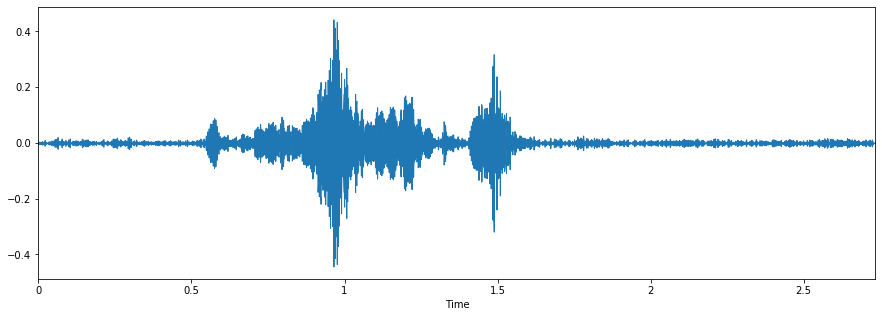

In [16]:
# use the well known Librosa library for this task 
fname = CREMA + '1012_IEO_HAP_HI.wav'  
data, sampling_rate = librosa.load(fname)
plt.figure(figsize=(15, 5))
librosa.display.waveplot(data, sr=sampling_rate)

# Lets play the audio 
ipd.Audio(fname)

So the audio itself is alittle echoey, for the lack of a better word. Its not as clear as what we've seen from the other data sets. And I'm not so sure if it'd consider the emotion happy. Sounds to me more like neutral. But then again, could be due to the audio quality. Lets listen to another one, a fearful one.  

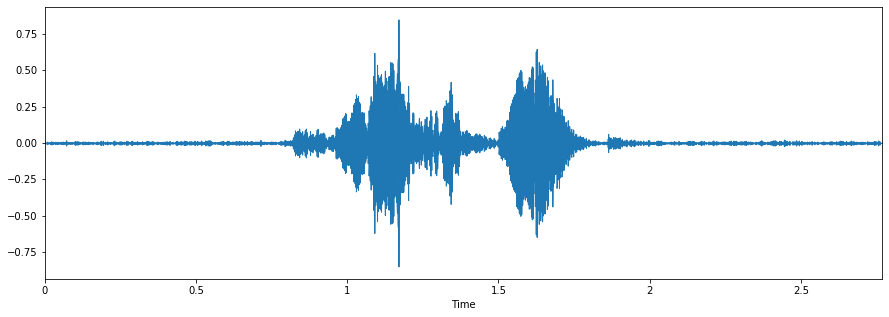

In [17]:
# A fearful track
fname = CREMA + '1012_IEO_FEA_HI.wav'  
data, sampling_rate = librosa.load(fname)
plt.figure(figsize=(15, 5))
librosa.display.waveplot(data, sr=sampling_rate)

# Lets play the audio 
ipd.Audio(fname)

<a id="crema_con"></a>
### Conclusion
The same sentence uttered and quite convincing that its a fearful emotion there. Much clearer than the happy version. Now, I went back to listen a few more random tracks and what I noticed with this CREMA-D dataset is that its is highly varied in its quality. Some are crisp clear and some are really muffled or echoey. Also there's lots of silence as well. All in all, slightly 'dirtier' version of the data. But still good quality data none the less and we'll definitely use it. On the up side, a slightly noisy dataset would serve as a very good data augmentation by introducing noise to the pattern which we don't have so far. 

<a id="final"></a>
##  <center> 5. Final thoughts<center>
All 4 dataset are good datasets. Having listen to them and doing some really rough inspections, I feel we can combine all of them. We need to anyway or else we will run into problems with overfitting. One of the issues that I see many other people before me who have made an attempt on an emotion classifier, they tend to stick to just one dataset. And whilst their hold-out set accuracy is high, they don't work well on new unseen dataset. 
    
This is because, the classifier is trained on the same dataset and given the similar circumstances that the dataset was obtained or produced, (eg. audio quality, speaker repetition, duration and sentence uttered). To enable it to do well on new datasets, it needs to be given noise, make it work hard to find the real distinguishing characteristics of the emotion.

Before we end it, final steps are to combine all the meta-data together as one. Remember we saved the paths for all the audio files. So this will be handy when we need to read all 4 data sources in different folder structures. 

Upvote this notebook if you like, and be sure to check out the other parts which are now available:
* [Part 2 | Feature Extract](https://www.kaggle.com/ejlok1/audio-emotion-part-2-feature-extract)
* [Part 3 | Baseline model](https://www.kaggle.com/ejlok1/audio-emotion-part-3-baseline-model)
* [Part 4 | Apply to new audio data](https://www.kaggle.com/ejlok1/audio-emotion-part-4-apply-to-new-audio-data)

In [18]:
df = pd.concat([SAVEE_df, RAV_df, TESS_df, CREMA_df], axis = 0)
print(df.labels.value_counts())
df.head()
df.to_csv("Data_path.csv",index=False)

female_disgust     1096
female_happy       1096
female_sad         1096
female_fear        1096
female_angry       1096
female_neutral     1056
male_neutral        839
male_sad            827
male_fear           827
male_angry          827
male_disgust        827
male_happy          827
female_surprise     496
male_surprise       156
Name: labels, dtype: int64


In [19]:
# Import our libraries
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import specgram
import pandas as pd
import os
import IPython.display as ipd  # To play sound in the notebook

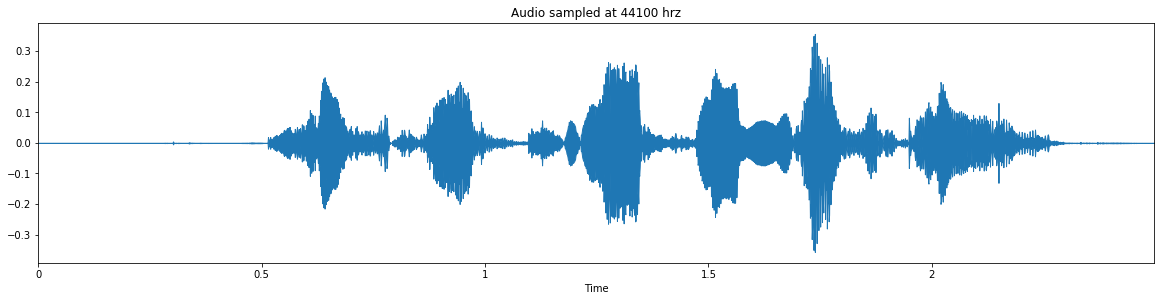

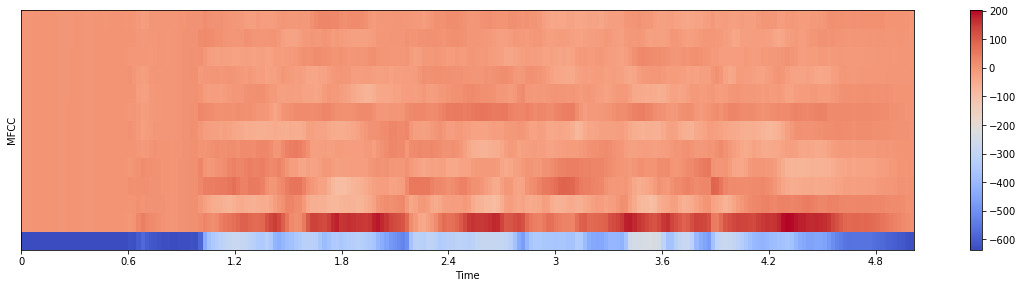

In [21]:
# Source - RAVDESS; Gender - Female; Emotion - Angry 
path = "E:/Dataset/RAVDESS/audio/Actor_08/03-01-05-02-01-01-08.wav"
X, sample_rate = librosa.load(path, res_type='kaiser_fast',duration=2.5,sr=22050*2,offset=0.5)  
mfcc = librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13)

# audio wave
plt.figure(figsize=(20, 15))
plt.subplot(3,1,1)
librosa.display.waveplot(X, sr=sample_rate)
plt.title('Audio sampled at 44100 hrz')

# MFCC
plt.figure(figsize=(20, 15))
plt.subplot(3,1,1)
librosa.display.specshow(mfcc, x_axis='time')
plt.ylabel('MFCC')
plt.colorbar()

ipd.Audio(path)

In [22]:
# Source - RAVDESS; Gender - Male; Emotion - Angry 
path = "/kaggle/input/ravdess-emotional-speech-audio/audio_speech_actors_01-24/Actor_09/03-01-05-01-01-01-09.wav"
X, sample_rate = librosa.load(path, res_type='kaiser_fast',duration=2.5,sr=22050*2,offset=0.5)  
mfcc = librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13)

# audio wave
plt.figure(figsize=(20, 15))
plt.subplot(3,1,1)
librosa.display.waveplot(X, sr=sample_rate)
plt.title('Audio sampled at 44100 hrz')

# MFCC
plt.figure(figsize=(20, 15))
plt.subplot(3,1,1)
librosa.display.specshow(mfcc, x_axis='time')
plt.ylabel('MFCC')
plt.colorbar()

ipd.Audio(path)

FileNotFoundError: [Errno 2] No such file or directory: 'C:\\kaggle\\input\\ravdess-emotional-speech-audio\\audio_speech_actors_01-24\\Actor_09\\03-01-05-01-01-01-09.wav'

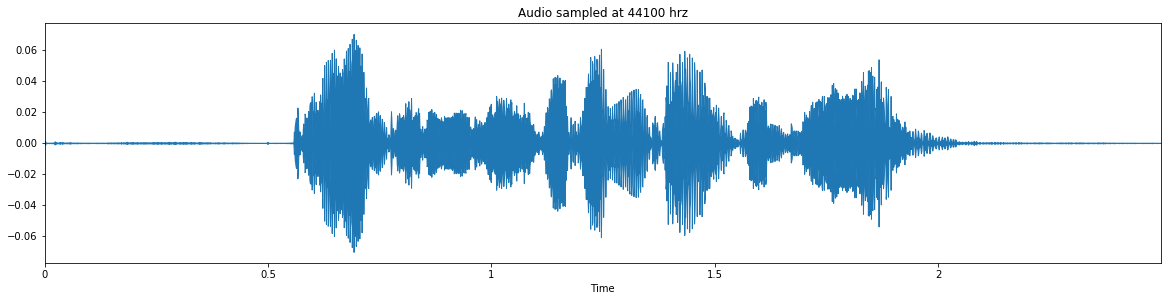

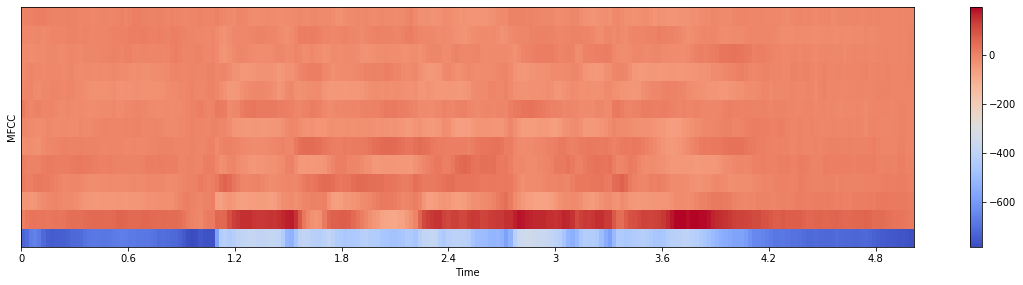

In [24]:
# Source - RAVDESS; Gender - Female; Emotion - Happy 
path = "E:/Dataset/RAVDESS/audio/Actor_12/03-01-03-01-02-01-12.wav"
X, sample_rate = librosa.load(path, res_type='kaiser_fast',duration=2.5,sr=22050*2,offset=0.5)  
mfcc = librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13)

# audio wave
plt.figure(figsize=(20, 15))
plt.subplot(3,1,1)
librosa.display.waveplot(X, sr=sample_rate)
plt.title('Audio sampled at 44100 hrz')

# MFCC
plt.figure(figsize=(20, 15))
plt.subplot(3,1,1)
librosa.display.specshow(mfcc, x_axis='time')
plt.ylabel('MFCC')
plt.colorbar()

ipd.Audio(path)

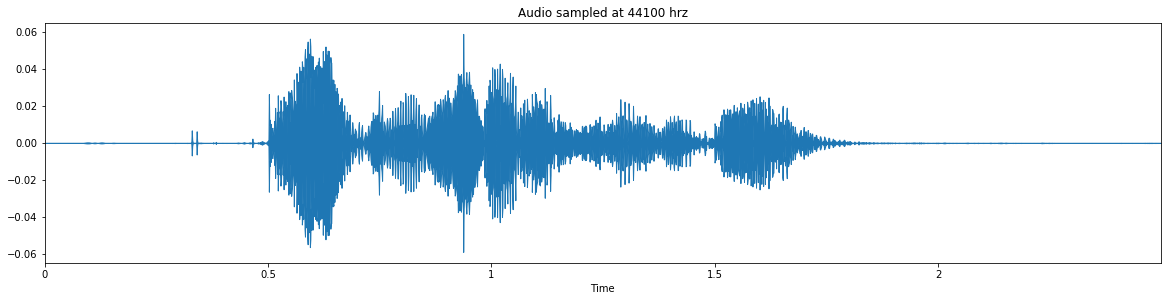

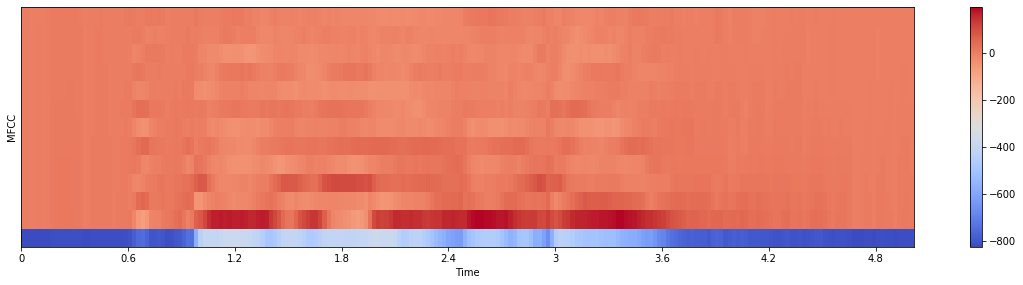

In [25]:
# Source - RAVDESS; Gender - Male; Emotion - Happy 
path = "E:/Dataset/RAVDESS/audio/Actor_11/03-01-03-01-02-02-11.wav"
X, sample_rate = librosa.load(path, res_type='kaiser_fast',duration=2.5,sr=22050*2,offset=0.5)  
mfcc = librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13)

# audio wave
plt.figure(figsize=(20, 15))
plt.subplot(3,1,1)
librosa.display.waveplot(X, sr=sample_rate)
plt.title('Audio sampled at 44100 hrz')

# MFCC
plt.figure(figsize=(20, 15))
plt.subplot(3,1,1)
librosa.display.specshow(mfcc, x_axis='time')
plt.ylabel('MFCC')
plt.colorbar()

ipd.Audio(path)

216
216


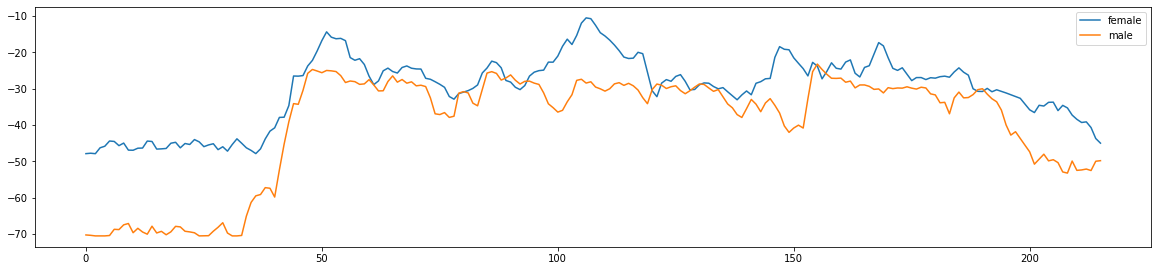

In [26]:
# Source - RAVDESS; Gender - Female; Emotion - Angry 
path = "E:/Dataset/RAVDESS/audio/Actor_08/03-01-05-02-01-01-08.wav"
X, sample_rate = librosa.load(path, res_type='kaiser_fast',duration=2.5,sr=22050*2,offset=0.5)  
female = librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13)
female = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13), axis=0)
print(len(female))

# Source - RAVDESS; Gender - Male; Emotion - Angry 
path = "E:/Dataset/RAVDESS/audio/Actor_09/03-01-05-01-01-01-09.wav"
X, sample_rate = librosa.load(path, res_type='kaiser_fast',duration=2.5,sr=22050*2,offset=0.5)  
male = librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13)
male = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13), axis=0)
print(len(male))

# audio wave
plt.figure(figsize=(20, 15))
plt.subplot(3,1,1)
plt.plot(female, label='female')
plt.plot(male, label='male')
plt.legend()

216
216


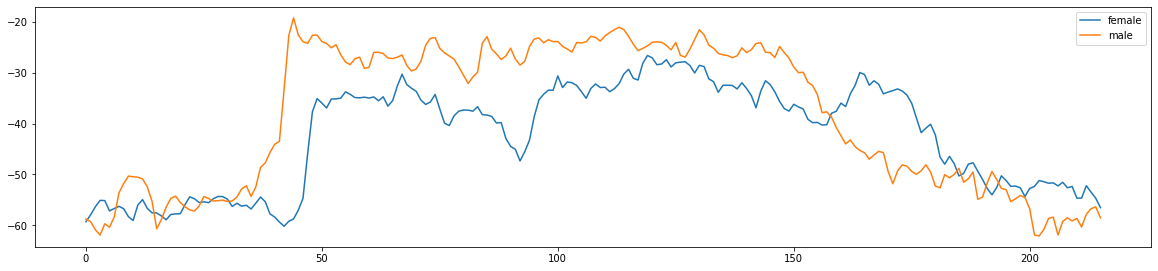

In [27]:
# Source - RAVDESS; Gender - Female; Emotion - happy 
path = "E:/Dataset/RAVDESS/audio/Actor_12/03-01-03-01-02-01-12.wav"
X, sample_rate = librosa.load(path, res_type='kaiser_fast',duration=2.5,sr=22050*2,offset=0.5)  
female = librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13)
female = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13), axis=0)
print(len(female))

# Source - RAVDESS; Gender - Male; Emotion - happy 
path = "E:/Dataset/RAVDESS/audio/Actor_11/03-01-03-01-02-02-11.wav"
X, sample_rate = librosa.load(path, res_type='kaiser_fast',duration=2.5,sr=22050*2,offset=0.5)  
male = librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13)
male = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13), axis=0)
print(len(male))

# Plot the two audio waves together
plt.figure(figsize=(20, 15))
plt.subplot(3,1,1)
plt.plot(female, label='female')
plt.plot(male, label='male')
plt.legend()

In [28]:
# lets pick up the meta-data that we got from our first part of the Kernel
#df.to_csv("Data_path.csv",index=False)
ref = pd.read_csv("Data_path.csv")
ref.head()

labels source                             path
0  male_angry  SAVEE  E:/Dataset/SAVEE/ALL/DC_a01.wav
1  male_angry  SAVEE  E:/Dataset/SAVEE/ALL/DC_a02.wav
2  male_angry  SAVEE  E:/Dataset/SAVEE/ALL/DC_a03.wav
3  male_angry  SAVEE  E:/Dataset/SAVEE/ALL/DC_a04.wav
4  male_angry  SAVEE  E:/Dataset/SAVEE/ALL/DC_a05.wav

In [29]:
# Note this takes a couple of minutes (~10 mins) as we're iterating over 4 datasets 
df = pd.DataFrame(columns=['feature'])

# loop feature extraction over the entire dataset
counter=0
for index,path in enumerate(ref.path):
    X, sample_rate = librosa.load(path
                                  , res_type='kaiser_fast'
                                  ,duration=2.5
                                  ,sr=44100
                                  ,offset=0.5
                                 )
    sample_rate = np.array(sample_rate)
    
    # mean as the feature. Could do min and max etc as well. 
    mfccs = np.mean(librosa.feature.mfcc(y=X, 
                                        sr=sample_rate, 
                                        n_mfcc=13),
                    axis=0)
    df.loc[counter] = [mfccs]
    counter=counter+1   

# Check a few records to make sure its processed successfully
print(len(df))
df.head()

12162


feature
0  [-11.113932639596916, -7.21575406254674, -6.21...
1  [-24.449830290856365, -22.46574285519743, -22....
2  [-25.00011578529051, -24.520253034986368, -24....
3  [-1.5298366991054984, -4.333434957825512, -12....
4  [-22.458639024772772, -22.467836912227312, -25...

In [30]:
# Now extract the mean bands to its own feature columns
df = pd.concat([ref,pd.DataFrame(df['feature'].values.tolist())],axis=1)
df[:5]

labels source                             path          0          1  \
0  male_angry  SAVEE  E:/Dataset/SAVEE/ALL/DC_a01.wav -11.113933  -7.215754   
1  male_angry  SAVEE  E:/Dataset/SAVEE/ALL/DC_a02.wav -24.449830 -22.465743   
2  male_angry  SAVEE  E:/Dataset/SAVEE/ALL/DC_a03.wav -25.000116 -24.520253   
3  male_angry  SAVEE  E:/Dataset/SAVEE/ALL/DC_a04.wav  -1.529837  -4.333435   
4  male_angry  SAVEE  E:/Dataset/SAVEE/ALL/DC_a05.wav -22.458639 -22.467837   

           2          3          4          5          6  ...        206  \
0  -6.219192  -5.926543  -5.850419  -4.808961  -2.513001  ...  -4.088851   
1 -22.928046 -23.243810 -22.926600 -23.432240 -14.830003  ... -22.627259   
2 -24.178188 -23.847449 -15.182787 -10.732486  -8.681473  ...        NaN   
3 -12.285239 -13.083026 -12.041327 -11.819770  -9.414149  ...        NaN   
4 -25.884357 -27.827048 -27.593531 -26.666511 -18.659022  ... -25.291668   

         207        208        209        210        211        212  \
0  -5.023862  -5.254715  -5.234093  -5.310309  -5.621665  -6.072197   
1 -22.633413 -22.511602 -24.300156 -24.496810 -22.895985 -23.511504   
2        NaN        NaN        NaN        NaN        NaN        NaN   
3        NaN        NaN        NaN        NaN        NaN        NaN   
4 -25.854909 -26.821354 -25.436453 -24.179943 -23.281619 -24.167497   

         213        214        215  
0  -6.611349  -2.509087   1.964607  
1 -24.342150 -24.530266 -25.457800  
2        NaN        NaN        NaN  
3        NaN        NaN        NaN  
4 -25.228065 -25.902942 -25.589965  

[5 rows x 219 columns]

In [31]:
# replace NA with 0
df=df.fillna(0)
print(df.shape)
df[:5]

(12162, 219)


labels source                             path          0          1  \
0  male_angry  SAVEE  E:/Dataset/SAVEE/ALL/DC_a01.wav -11.113933  -7.215754   
1  male_angry  SAVEE  E:/Dataset/SAVEE/ALL/DC_a02.wav -24.449830 -22.465743   
2  male_angry  SAVEE  E:/Dataset/SAVEE/ALL/DC_a03.wav -25.000116 -24.520253   
3  male_angry  SAVEE  E:/Dataset/SAVEE/ALL/DC_a04.wav  -1.529837  -4.333435   
4  male_angry  SAVEE  E:/Dataset/SAVEE/ALL/DC_a05.wav -22.458639 -22.467837   

           2          3          4          5          6  ...        206  \
0  -6.219192  -5.926543  -5.850419  -4.808961  -2.513001  ...  -4.088851   
1 -22.928046 -23.243810 -22.926600 -23.432240 -14.830003  ... -22.627259   
2 -24.178188 -23.847449 -15.182787 -10.732486  -8.681473  ...   0.000000   
3 -12.285239 -13.083026 -12.041327 -11.819770  -9.414149  ...   0.000000   
4 -25.884357 -27.827048 -27.593531 -26.666511 -18.659022  ... -25.291668   

         207        208        209        210        211        212  \
0  -5.023862  -5.254715  -5.234093  -5.310309  -5.621665  -6.072197   
1 -22.633413 -22.511602 -24.300156 -24.496810 -22.895985 -23.511504   
2   0.000000   0.000000   0.000000   0.000000   0.000000   0.000000   
3   0.000000   0.000000   0.000000   0.000000   0.000000   0.000000   
4 -25.854909 -26.821354 -25.436453 -24.179943 -23.281619 -24.167497   

         213        214        215  
0  -6.611349  -2.509087   1.964607  
1 -24.342150 -24.530266 -25.457800  
2   0.000000   0.000000   0.000000  
3   0.000000   0.000000   0.000000  
4 -25.228065 -25.902942 -25.589965  

[5 rows x 219 columns]

In [32]:
# Split between train and test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df.drop(['path','labels','source'],axis=1)
                                                    , df.labels
                                                    , test_size=0.25
                                                    , shuffle=True
                                                    , random_state=42
                                                   )

# Lets see how the data present itself before normalisation 
X_train[150:160]

0          1          2          3          4          5    \
4950  -18.611181 -17.616534 -18.411488 -18.987419 -17.404622 -16.747272   
3860  -10.786573 -14.882178 -23.087039 -22.467030 -20.362328 -19.076140   
9761   -1.533948  -4.030604  -9.614024 -12.045175  -9.992991 -11.926252   
7620   -4.531078  -3.933792  -4.567835  -5.871508  -5.282477  -6.490460   
11586 -20.621704 -21.587511 -20.563646 -20.703459 -21.205716 -18.608532   
7914  -17.514992 -18.551865 -17.043017 -16.977908 -19.369631 -19.562126   
9513  -18.740371 -18.824932 -16.149491 -16.963455 -18.229979 -18.183954   
5835  -19.066850 -18.328381 -17.710285 -18.043194 -18.252480 -18.710627   
5389  -20.760591 -20.047141 -18.961349 -19.468693 -19.316294 -18.162563   
11222 -18.252922 -17.727369 -19.222475 -18.469974 -17.572321 -17.850541   

             6          7          8          9    ...        206        207  \
4950  -17.733749 -18.055029 -17.931204 -15.913174  ... -22.899401 -21.647812   
3860  -19.761509 -13.231025 -11.808995 -16.756003  ...   0.000000   0.000000   
9761  -14.008464 -13.561555 -14.024567 -15.151948  ...   0.000000   0.000000   
7620   -8.156468  -9.188806  -8.681726  -8.212408  ...   0.000000   0.000000   
11586 -18.446670 -16.211846 -14.257653 -15.160406  ...   0.000000   0.000000   
7914  -22.008752 -20.178384 -17.989597 -19.336282  ...   0.000000   0.000000   
9513  -19.274344 -18.395124 -16.951290 -16.672032  ... -17.882128 -19.390711   
5835  -16.626352 -17.831004 -18.028342 -17.859101  ...   0.000000   0.000000   
5389  -18.102335 -19.914138 -20.931389 -19.215491  ...   0.000000   0.000000   
11222 -17.932027 -20.588902 -18.612181 -15.990730  ... -18.065437 -18.135092   

             208        209        210        211        212        213  \
4950  -19.758652 -18.879398 -19.397377 -20.171656 -22.689246 -24.612815   
3860    0.000000   0.000000   0.000000   0.000000   0.000000   0.000000   
9761    0.000000   0.000000   0.000000   0.000000   0.000000   0.000000   
7620    0.000000   0.000000   0.000000   0.000000   0.000000   0.000000   
11586   0.000000   0.000000   0.000000   0.000000   0.000000   0.000000   
7914    0.000000   0.000000   0.000000   0.000000   0.000000   0.000000   
9513  -17.779470 -19.165972   0.000000   0.000000   0.000000   0.000000   
5835    0.000000   0.000000   0.000000   0.000000   0.000000   0.000000   
5389    0.000000   0.000000   0.000000   0.000000   0.000000   0.000000   
11222 -19.665306 -20.741905 -20.273032 -18.371031 -15.576724 -17.512488   

             214        215  
4950  -24.153772 -22.703135  
3860    0.000000   0.000000  
9761    0.000000   0.000000  
7620    0.000000   0.000000  
11586   0.000000   0.000000  
7914    0.000000   0.000000  
9513    0.000000   0.000000  
5835    0.000000   0.000000  
5389    0.000000   0.000000  
11222 -17.008546 -18.195283  

[10 rows x 216 columns]

In [33]:
# Lts do data normalization 
mean = np.mean(X_train, axis=0)
std = np.std(X_train, axis=0)

X_train = (X_train - mean)/std
X_test = (X_test - mean)/std

# Check the dataset now 
X_train[150:160]

0         1         2         3         4         5         6    \
4950   0.185662  0.302468  0.437165  0.387895  0.498989  0.543636  0.462580   
3860   0.732048  0.501149  0.089952  0.130028  0.280118  0.371251  0.312744   
9761   1.378151  1.289636  1.090478  0.902370  1.047452  0.900492  0.737849   
7620   1.168864  1.296670  1.465215  1.359888  1.396032  1.302854  1.170266   
11586  0.045269  0.013933  0.277342  0.260723  0.217707  0.405864  0.409900   
7914   0.262208  0.234506  0.538790  0.536816  0.353578  0.335278  0.146690   
9513   0.176641  0.214664  0.605144  0.537887  0.437912  0.437292  0.348742   
5835   0.153843  0.250744  0.489237  0.457870  0.436247  0.398307  0.544408   
5389   0.035570  0.125857  0.396331  0.352229  0.357525  0.438875  0.435344   
11222  0.210679  0.294415  0.376940  0.426242  0.486579  0.461971  0.447928   

            7         8         9    ...       206       207       208  \
4950   0.433146  0.435814  0.580897  ... -0.883216 -0.815256 -0.695046   
3860   0.788958  0.886902  0.518818  ...  0.540193  0.526315  0.525757   
9761   0.764579  0.723657  0.636966  ...  0.540193  0.526315  0.525757   
7620   1.087108  1.117321  1.148100  ...  0.540193  0.526315  0.525757   
11586  0.569097  0.706483  0.636343  ...  0.540193  0.526315  0.525757   
7914   0.276530  0.431512  0.328767  ...  0.540193  0.526315  0.525757   
9513   0.408061  0.508015  0.525003  ... -0.571346 -0.675378 -0.572761   
5835   0.449670  0.428657  0.437569  ...  0.540193  0.526315  0.525757   
5389   0.296020  0.214759  0.337664  ...  0.540193  0.526315  0.525757   
11222  0.246250  0.385640  0.575185  ... -0.582741 -0.597564 -0.689279   

            209       210       211       212       213       214       215  
4950  -0.633007 -0.679831 -0.722842 -0.865393 -0.989019 -0.972385 -0.882535  
3860   0.526696  0.511816  0.512069  0.512981  0.501471  0.496906  0.492873  
9761   0.526696  0.511816  0.512069  0.512981  0.501471  0.496906  0.492873  
7620   0.526696  0.511816  0.512069  0.512981  0.501471  0.496906  0.492873  
11586  0.526696  0.511816  0.512069  0.512981  0.501471  0.496906  0.492873  
7914   0.526696  0.511816  0.512069  0.512981  0.501471  0.496906  0.492873  
9513  -0.650610  0.511816  0.512069  0.512981  0.501471  0.496906  0.492873  
5835   0.526696  0.511816  0.512069  0.512981  0.501471  0.496906  0.492873  
5389   0.526696  0.511816  0.512069  0.512981  0.501471  0.496906  0.492873  
11222 -0.747415 -0.733626 -0.612607 -0.433306 -0.559041 -0.537736 -0.609439  

[10 rows x 216 columns]

In [34]:
max_data = np.max(X_train)
min_data = np.min(X_train)
X_train = (X_train-min_data)/(max_data-min_data+1e-6)
X_train =  X_train-0.5

max_data = np.max(X_test)
min_data = np.min(X_test)
X_test = (X_test-min_data)/(max_data-min_data+1e-6)
X_test =  X_test-0.5

X_train[150:160]

0         1         2         3         4         5         6    \
4950   0.225976  0.260507  0.229571  0.232577  0.280537  0.281269  0.273993   
3860   0.309003  0.290466  0.179858  0.195113  0.247379  0.255380  0.251344   
9761   0.407182  0.409360  0.323110  0.307322  0.363627  0.334861  0.315603   
7620   0.375380  0.410421  0.376764  0.373792  0.416435  0.395287  0.380967   
11586  0.204642  0.216999  0.206688  0.214101  0.237924  0.260578  0.266030   
7914   0.237608  0.250259  0.244121  0.254213  0.258507  0.249978  0.226243   
9513   0.224605  0.247267  0.253622  0.254368  0.271284  0.265298  0.256786   
5835   0.221141  0.252708  0.237027  0.242743  0.271032  0.259443  0.286362   
5389   0.203168  0.233876  0.223725  0.227395  0.259105  0.265536  0.269876   
11222  0.229777  0.259293  0.220948  0.238148  0.278657  0.269004  0.271779   

            7         8         9    ...       206       207       208  \
4950   0.271421  0.271276  0.308196  ...  0.194599  0.211055  0.238353   
3860   0.325374  0.339613  0.298617  ...  0.492531  0.492602  0.486273   
9761   0.321677  0.314882  0.316847  ...  0.492531  0.492602  0.486273   
7620   0.370583  0.374520  0.395711  ...  0.492531  0.492602  0.486273   
11586  0.292036  0.312280  0.316750  ...  0.492531  0.492602  0.486273   
7914   0.247673  0.270624  0.269293  ...  0.492531  0.492602  0.486273   
9513   0.267617  0.282213  0.299571  ...  0.259876  0.240411  0.263187   
5835   0.273926  0.270191  0.286081  ...  0.492531  0.492602  0.486273   
5389   0.250628  0.237787  0.270666  ...  0.492531  0.492602  0.486273   
11222  0.243081  0.263674  0.307314  ...  0.257492  0.256741  0.239524   

            209       210       211       212       213       214       215  
4950   0.252237  0.235715  0.238385  0.214614  0.171467  0.164676  0.139370  
3860   0.492898  0.491642  0.495417  0.500000  0.494098  0.472364  0.410042  
9761   0.492898  0.491642  0.495417  0.500000  0.494098  0.472364  0.410042  
7620   0.492898  0.491642  0.495417  0.500000  0.494098  0.472364  0.410042  
11586  0.492898  0.491642  0.495417  0.500000  0.494098  0.472364  0.410042  
7914   0.492898  0.491642  0.495417  0.500000  0.494098  0.472364  0.410042  
9513   0.248584  0.491642  0.495417  0.500000  0.494098  0.472364  0.410042  
5835   0.492898  0.491642  0.495417  0.500000  0.494098  0.472364  0.410042  
5389   0.492898  0.491642  0.495417  0.500000  0.494098  0.472364  0.410042  
11222  0.228495  0.224162  0.261329  0.304076  0.264540  0.255697  0.193114  

[10 rows x 216 columns]

In [35]:
print(type(y_train))

<class 'pandas.core.series.Series'>


In [36]:
import keras
from keras import regularizers
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential, Model, model_from_json
from keras.layers import Dense, Embedding, LSTM
from keras.layers import Input, Flatten, Dropout, Activation, BatchNormalization
from keras.layers import Conv1D, MaxPooling1D, AveragePooling1D
from keras.utils import np_utils, to_categorical
from keras.callbacks import ModelCheckpoint

# sklearn
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Other  
import librosa
import librosa.display
import json
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from matplotlib.pyplot import specgram
import pandas as pd
import seaborn as sns
import glob 
import os
import pickle
import IPython.display as ipd 

Using TensorFlow backend.


In [37]:
# Lets few preparation steps to get it into the correct format for Keras 
X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)

# one hot encode the target 
from sklearn.preprocessing import LabelEncoder
from keras.utils import np_utils, to_categorical
lb = LabelEncoder()
y_train = np_utils.to_categorical(lb.fit_transform(y_train))
y_test = np_utils.to_categorical(lb.fit_transform(y_test))

print(X_train.shape)
print(lb.classes_)
#print(y_train[0:10])
#print(y_test[0:10])

import pickle
# Pickel the lb object for future use 
filename = 'labels'
outfile = open(filename,'wb')
pickle.dump(lb,outfile)
outfile.close()

(9121, 216)
['female_angry' 'female_disgust' 'female_fear' 'female_happy'
 'female_neutral' 'female_sad' 'female_surprise' 'male_angry'
 'male_disgust' 'male_fear' 'male_happy' 'male_neutral' 'male_sad'
 'male_surprise']


In [38]:
X_train = np.expand_dims(X_train, axis=2)
X_test = np.expand_dims(X_test, axis=2)
X_train.shape

(9121, 216, 1)

In [39]:
# New model
model = Sequential()
model.add(Conv1D(256, 8, padding='same',input_shape=(X_train.shape[1],1)))  # X_train.shape[1] = No. of Columns
model.add(Activation('relu'))
model.add(Conv1D(256, 8, padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))
model.add(MaxPooling1D(pool_size=(8)))
model.add(Conv1D(128, 8, padding='same'))
model.add(Activation('relu'))
model.add(Conv1D(128, 8, padding='same'))
model.add(Activation('relu'))
model.add(Conv1D(128, 8, padding='same'))
model.add(Activation('relu'))
model.add(Conv1D(128, 8, padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))
model.add(MaxPooling1D(pool_size=(8)))
model.add(Conv1D(64, 8, padding='same'))
model.add(Activation('relu'))
model.add(Conv1D(64, 8, padding='same'))
model.add(Activation('relu'))
model.add(Flatten())
model.add(Dense(14)) # Target class number
model.add(Activation('softmax'))
# opt = keras.optimizers.SGD(lr=0.0001, momentum=0.0, decay=0.0, nesterov=False)
# opt = keras.optimizers.Adam(lr=0.0001)
opt = keras.optimizers.rmsprop(lr=0.00001, decay=1e-6)
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 216, 256)          2304      
_________________________________________________________________
activation_1 (Activation)    (None, 216, 256)          0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 216, 256)          524544    
_________________________________________________________________
batch_normalization_1 (Batch (None, 216, 256)          1024      
_________________________________________________________________
activation_2 (Activation)    (None, 216, 256)          0         
_________________________________________________________________
dropout_1 (Dropout)  

In [40]:
model.compile(loss='categorical_crossentropy', optimizer=opt,metrics=['accuracy'])
model_history=model.fit(X_train, y_train, batch_size=16, epochs=10, validation_data=(X_test, y_test))

Instructions for updating:
Use tf.cast instead.
Train on 9121 samples, validate on 3041 samples
Epoch 1/10
9121/9121 [==============================] - 207s 23ms/step - loss: 2.4780 - acc: 0.1840 - val_loss: 2.4671 - val_acc: 0.1651
Epoch 2/10
9121/9121 [==============================] - 267s 29ms/step - loss: 2.2842 - acc: 0.2393 - val_loss: 2.4226 - val_acc: 0.1562
Epoch 3/10
9121/9121 [==============================] - 270s 30ms/step - loss: 2.1852 - acc: 0.2599 - val_loss: 2.4013 - val_acc: 0.1802
Epoch 4/10
9121/9121 [==============================] - 269s 30ms/step - loss: 2.1171 - acc: 0.2769 - val_loss: 2.3591 - val_acc: 0.1749
Epoch 5/10
9121/9121 [==============================] - 271s 30ms/step - loss: 2.0547 - acc: 0.2979 - val_loss: 2.3286 - val_acc: 0.2006
Epoch 6/10
9121/9121 [==============================] - 270s 30ms/step - loss: 2.0022 - acc: 0.3080 - val_loss: 2.2779 - val_acc: 0.2183
Epoch 7/10
9121/9121 [==============================] - 279s 31ms/step - loss: 1.9

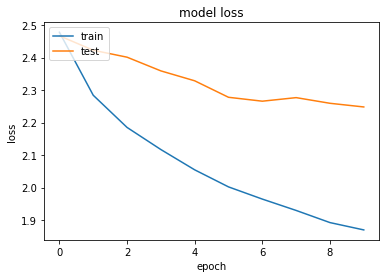

In [41]:
plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [42]:
# Save model and weights
model_name = 'Emotion_Model.h5'
save_dir = os.path.join(os.getcwd(), 'saved_models')

if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
model_path = os.path.join(save_dir, model_name)
model.save(model_path)
print('Save model and weights at %s ' % model_path)

# Save the model to disk
model_json = model.to_json()
with open("model_json.json", "w") as json_file:
    json_file.write(model_json)

Save model and weights at C:\Users\ayush\Downloads\saved_models\Emotion_Model.h5 


In [43]:
# loading json and model architecture 
json_file = open('model_json.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)

# load weights into new model
loaded_model.load_weights("saved_models/Emotion_Model.h5")
print("Loaded model from disk")
 
# Keras optimiser
opt = keras.optimizers.rmsprop(lr=0.00001, decay=1e-6)
loaded_model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
score = loaded_model.evaluate(X_test, y_test, verbose=0)
print("%s: %.2f%%" % (loaded_model.metrics_names[1], score[1]*100))

Loaded model from disk
acc: 22.95%


In [44]:
preds = loaded_model.predict(X_test, 
                         batch_size=16, 
                         verbose=1)

preds=preds.argmax(axis=1)
preds

3041/3041 [==============================] - 25s 8ms/step


array([ 3,  2,  8, ...,  3,  1, 10], dtype=int64)

In [45]:
# predictions 
preds = preds.astype(int).flatten()
preds = (lb.inverse_transform((preds)))
preds = pd.DataFrame({'predictedvalues': preds})

# Actual labels
actual=y_test.argmax(axis=1)
actual = actual.astype(int).flatten()
actual = (lb.inverse_transform((actual)))
actual = pd.DataFrame({'actualvalues': actual})

# Lets combined both of them into a single dataframe
finaldf = actual.join(preds)
finaldf[170:180]

actualvalues predictedvalues
170        male_sad  female_disgust
171  female_neutral      female_sad
172      male_angry    male_neutral
173  female_disgust  female_disgust
174      male_angry      male_angry
175     female_fear        male_sad
176    male_neutral    male_neutral
177     female_fear    female_happy
178    female_happy     female_fear
179  female_neutral  female_neutral

In [46]:
# Write out the predictions to disk
finaldf.to_csv('Predictions.csv', index=False)
finaldf.groupby('predictedvalues').count()

actualvalues
predictedvalues              
female_angry               31
female_disgust            762
female_fear               238
female_happy              435
female_neutral            129
female_sad                422
female_surprise           145
male_angry                 57
male_disgust              100
male_fear                   3
male_happy                448
male_neutral              134
male_sad                  137

In [47]:
# the confusion matrix heat map plot
def print_confusion_matrix(confusion_matrix, class_names, figsize = (10,7), fontsize=14):
    """Prints a confusion matrix, as returned by sklearn.metrics.confusion_matrix, as a heatmap.
    
    Arguments
    ---------
    confusion_matrix: numpy.ndarray
        The numpy.ndarray object returned from a call to sklearn.metrics.confusion_matrix. 
        Similarly constructed ndarrays can also be used.
    class_names: list
        An ordered list of class names, in the order they index the given confusion matrix.
    figsize: tuple
        A 2-long tuple, the first value determining the horizontal size of the ouputted figure,
        the second determining the vertical size. Defaults to (10,7).
    fontsize: int
        Font size for axes labels. Defaults to 14.
        
    Returns
    -------
    matplotlib.figure.Figure
        The resulting confusion matrix figure
    """
    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names, 
    )
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
        
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Gender recode function
def gender(row):
    if row == 'female_disgust' or 'female_fear' or 'female_happy' or 'female_sad' or 'female_surprise' or 'female_neutral':
        return 'female'
    elif row == 'male_angry' or 'male_fear' or 'male_happy' or 'male_sad' or 'male_surprise' or 'male_neutral' or 'male_disgust':
        return 'male'


0.22952975994738573


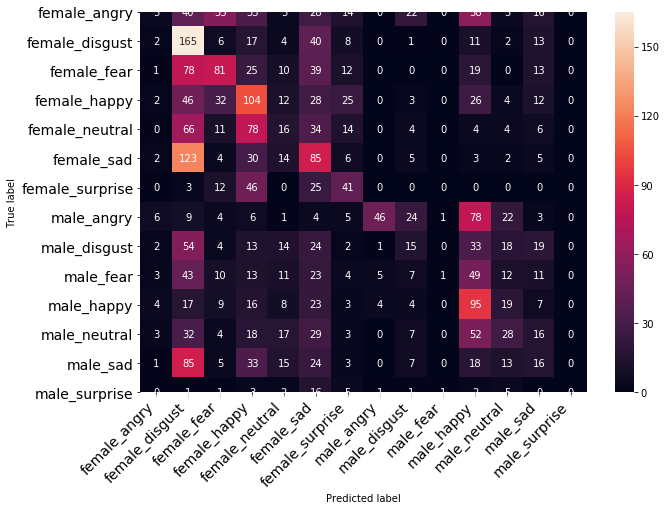

In [48]:
# Get the predictions file 
finaldf = pd.read_csv("Predictions.csv")
classes = finaldf.actualvalues.unique()
classes.sort()    

# Confusion matrix 
c = confusion_matrix(finaldf.actualvalues, finaldf.predictedvalues)
print(accuracy_score(finaldf.actualvalues, finaldf.predictedvalues))
print_confusion_matrix(c, class_names = classes)

In [49]:
# Classification report 
classes = finaldf.actualvalues.unique()
classes.sort()    
print(classification_report(finaldf.actualvalues, finaldf.predictedvalues, target_names=classes))

                 precision    recall  f1-score   support

   female_angry       0.16      0.02      0.03       281
 female_disgust       0.22      0.61      0.32       269
    female_fear       0.34      0.29      0.31       278
   female_happy       0.24      0.35      0.29       294
 female_neutral       0.12      0.07      0.09       237
     female_sad       0.20      0.30      0.24       279
female_surprise       0.28      0.32      0.30       127
     male_angry       0.81      0.22      0.35       209
   male_disgust       0.15      0.08      0.10       199
      male_fear       0.33      0.01      0.01       192
     male_happy       0.21      0.45      0.29       209
   male_neutral       0.21      0.13      0.16       209
       male_sad       0.12      0.07      0.09       220
  male_surprise       0.00      0.00      0.00        38

       accuracy                           0.23      3041
      macro avg       0.24      0.21      0.18      3041
   weighted avg       0.25   

C:\Users\ayush\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\ayush\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\ayush\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


0.7129233804669517


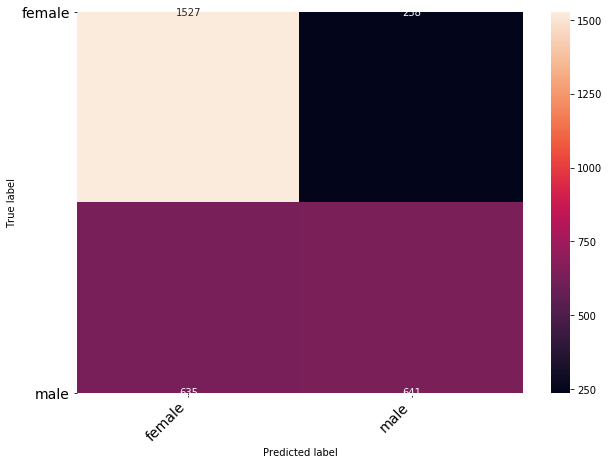

In [50]:
modidf = finaldf
modidf['actualvalues'] = finaldf.actualvalues.replace({'female_angry':'female'
                                       , 'female_disgust':'female'
                                       , 'female_fear':'female'
                                       , 'female_happy':'female'
                                       , 'female_sad':'female'
                                       , 'female_surprise':'female'
                                       , 'female_neutral':'female'
                                       , 'male_angry':'male'
                                       , 'male_fear':'male'
                                       , 'male_happy':'male'
                                       , 'male_sad':'male'
                                       , 'male_surprise':'male'
                                       , 'male_neutral':'male'
                                       , 'male_disgust':'male'
                                      })

modidf['predictedvalues'] = finaldf.predictedvalues.replace({'female_angry':'female'
                                       , 'female_disgust':'female'
                                       , 'female_fear':'female'
                                       , 'female_happy':'female'
                                       , 'female_sad':'female'
                                       , 'female_surprise':'female'
                                       , 'female_neutral':'female'
                                       , 'male_angry':'male'
                                       , 'male_fear':'male'
                                       , 'male_happy':'male'
                                       , 'male_sad':'male'
                                       , 'male_surprise':'male'
                                       , 'male_neutral':'male'
                                       , 'male_disgust':'male'
                                      })

classes = modidf.actualvalues.unique()  
classes.sort() 

# Confusion matrix 
c = confusion_matrix(modidf.actualvalues, modidf.predictedvalues)
print(accuracy_score(modidf.actualvalues, modidf.predictedvalues))
print_confusion_matrix(c, class_names = classes)

In [51]:
# Classification report 
classes = modidf.actualvalues.unique()
classes.sort()    
print(classification_report(modidf.actualvalues, modidf.predictedvalues, target_names=classes))

              precision    recall  f1-score   support

      female       0.71      0.87      0.78      1765
        male       0.73      0.50      0.59      1276

    accuracy                           0.71      3041
   macro avg       0.72      0.68      0.69      3041
weighted avg       0.72      0.71      0.70      3041



0.2847747451496218


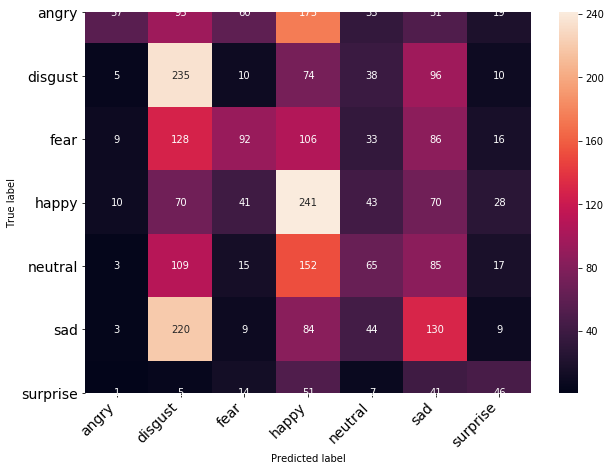

In [52]:
modidf = pd.read_csv("Predictions.csv")
modidf['actualvalues'] = modidf.actualvalues.replace({'female_angry':'angry'
                                       , 'female_disgust':'disgust'
                                       , 'female_fear':'fear'
                                       , 'female_happy':'happy'
                                       , 'female_sad':'sad'
                                       , 'female_surprise':'surprise'
                                       , 'female_neutral':'neutral'
                                       , 'male_angry':'angry'
                                       , 'male_fear':'fear'
                                       , 'male_happy':'happy'
                                       , 'male_sad':'sad'
                                       , 'male_surprise':'surprise'
                                       , 'male_neutral':'neutral'
                                       , 'male_disgust':'disgust'
                                      })

modidf['predictedvalues'] = modidf.predictedvalues.replace({'female_angry':'angry'
                                       , 'female_disgust':'disgust'
                                       , 'female_fear':'fear'
                                       , 'female_happy':'happy'
                                       , 'female_sad':'sad'
                                       , 'female_surprise':'surprise'
                                       , 'female_neutral':'neutral'
                                       , 'male_angry':'angry'
                                       , 'male_fear':'fear'
                                       , 'male_happy':'happy'
                                       , 'male_sad':'sad'
                                       , 'male_surprise':'surprise'
                                       , 'male_neutral':'neutral'
                                       , 'male_disgust':'disgust'
                                      })

classes = modidf.actualvalues.unique() 
classes.sort() 

# Confusion matrix 
c = confusion_matrix(modidf.actualvalues, modidf.predictedvalues)
print(accuracy_score(modidf.actualvalues, modidf.predictedvalues))
print_confusion_matrix(c, class_names = classes)

In [53]:
# Classification report 
classes = modidf.actualvalues.unique()
classes.sort()    
print(classification_report(modidf.actualvalues, modidf.predictedvalues, target_names=classes))

              precision    recall  f1-score   support

       angry       0.65      0.12      0.20       490
     disgust       0.27      0.50      0.35       468
        fear       0.38      0.20      0.26       470
       happy       0.27      0.48      0.35       503
     neutral       0.25      0.15      0.18       446
         sad       0.23      0.26      0.25       499
    surprise       0.32      0.28      0.30       165

    accuracy                           0.28      3041
   macro avg       0.34      0.28      0.27      3041
weighted avg       0.34      0.28      0.27      3041



In [54]:
python -m pip install pyaudio

SyntaxError: invalid syntax (<ipython-input-54-31468ba23be5>, line 1)

In [55]:
from keras.models import Sequential, Model, model_from_json
import matplotlib.pyplot as plt
import keras 
import pickle
import wave  # !pip install wave
import os
import pandas as pd
import numpy as np
import sys
import pyaudio
import warnings
import librosa
import librosa.display
import IPython.display as ipd  # To play sound in the notebook

# ignore warnings 
if not sys.warnoptions:
    warnings.simplefilter("ignore")

In [76]:
import pyaudio
CHUNK = 1024 
FORMAT = pyaudio.paInt16 
CHANNELS = 2 
RATE = 44100 
RECORD_SECONDS = 4
WAVE_OUTPUT_FILENAME = "testing.wav"

p = pyaudio.PyAudio()

stream = p.open(format=FORMAT,
                channels=CHANNELS,
                rate=RATE,
                input=True,
                frames_per_buffer=CHUNK) #buffer

print("* recording")

frames = []

for i in range(0, int(RATE / CHUNK * RECORD_SECONDS)):
    data = stream.read(CHUNK)
    frames.append(data) # 2 bytes(16 bits) per channel

print("* done recording")

stream.stop_stream()
stream.close()
p.terminate()

wf = wave.open(WAVE_OUTPUT_FILENAME, 'wb')
wf.setnchannels(CHANNELS)
wf.setsampwidth(p.get_sample_size(FORMAT))
wf.setframerate(RATE)
wf.writeframes(b''.join(frames))
wf.close()

* recording
* done recording


In [77]:
data, sampling_rate = librosa.load('testing.wav')
ipd.Audio('testing.wav')

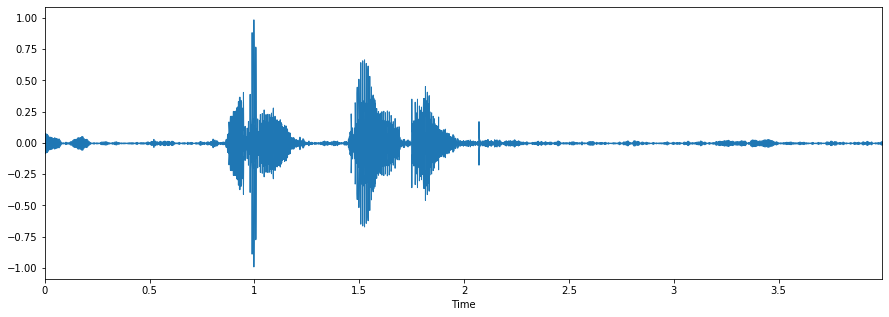

In [78]:
plt.figure(figsize=(15, 5))
librosa.display.waveplot(data, sr=sampling_rate)

In [79]:
# loading json and model architecture 
json_file = open('model_json.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)

# load weights into new model
loaded_model.load_weights("C:/Users/ayush/Downloads/saved_models/Emotion_Model.h5")
print("Loaded model from disk")

# the optimiser
opt = keras.optimizers.rmsprop(lr=0.00001, decay=1e-6)
loaded_model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

Loaded model from disk


In [80]:
X, sample_rate = librosa.load('testing.wav'
                              ,res_type='kaiser_fast'
                              ,duration=2.5
                              ,sr=44100
                              ,offset=0.5
                             )

sample_rate = np.array(sample_rate)
mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13),axis=0)
newdf = pd.DataFrame(data=mfccs).T
newdf

0          1          2          3          4          5    \
0 -17.819875 -12.566888 -12.933249 -17.465673 -19.063647 -19.622911   

         6          7          8          9    ...        206        207  \
0 -20.144124 -19.562531 -18.942386 -19.777099  ... -22.705137 -20.326477   

        208        209        210        211        212        213        214  \
0 -23.74008 -24.080393 -21.908336 -23.937383 -23.632711 -22.546923 -23.569826   

         215  
0 -24.062747  

[1 rows x 216 columns]

In [81]:
newdf= np.expand_dims(newdf, axis=2)
newpred = loaded_model.predict(newdf, 
                         batch_size=16, 
                         verbose=1)

newpred

1/1 [==============================] - 1s 1s/step


array([[1.9952715e-16, 0.0000000e+00, 2.5716743e-30, 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 2.6921158e-12,
        0.0000000e+00, 5.2194076e-26, 9.1400958e-12, 1.0000000e+00,
        0.0000000e+00, 4.7418023e-34]], dtype=float32)

In [82]:
filename = 'labels'
infile = open(filename,'rb')
lb = pickle.load(infile)
infile.close()

# Get the final predicted label
final = newpred.argmax(axis=1)
final = final.astype(int).flatten()
final = (lb.inverse_transform((final)))
print(final) #e

['male_neutral']
